# Practical Natural Language Processing Tutorial (Session 2)

Our expectations for the outcome of this session:

* Use the [🤗 Hugging Face](https://huggingface.co/) to learn how to use `transformers`. 

* Learn how to utilize different interfaces this library provided for us, such as `pipeline`, `ModelForSequenceClassification`, etc.

* Learn what is `Tokenizer` and what are differences between different techniques of tokenizing sentences.

Resources:

* [🤗 Hugging Face Course](https://huggingface.co/course)

In [ ]:
%pip install transformers tokenizers datasets

from tqdm.notebook import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

clear_output()

In [ ]:
#@title Upload `kaggle.json`
# We use kaggle library to download dataset directly to colab notebook
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

clear_output()
print('done')

done


## Pipeline


```
my_pipeline = pipeline(task_name, model=model_name)
```

The following options are available for `task_name`:

*     feature-extraction (get the vector representation of a text)
*     fill-mask
*     NER (named entity recognition)
*     question-answering
*     sentiment-analysis
*     summarization
*     text-generation
*     translation
*     zero-shot-classification

Model name can be chosen from the [🤗 Hugging Face Hub](https://huggingface.co/models)!


<img src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg" width=800 />

In [ ]:
from transformers import pipeline

### `fill-mask`

In [ ]:
model_name = "bert-base-cased" #@param {type:"string"}

unmasker = pipeline('fill-mask', model=model_name)

clear_output()

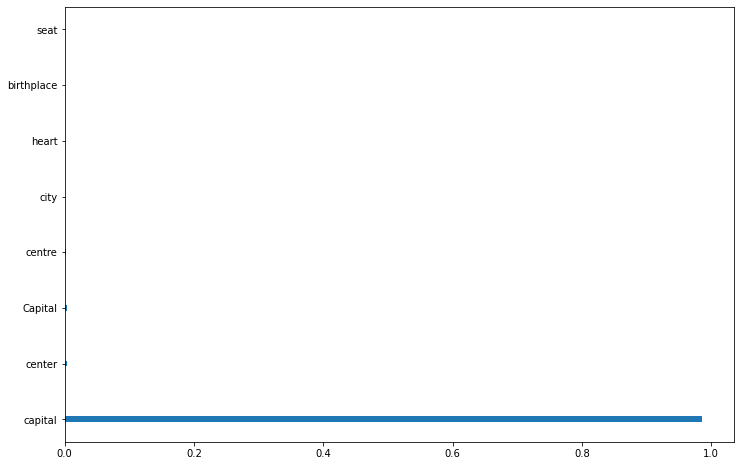

In [ ]:
input_sentence = "Paris is the [MASK] of France." #@param {type:"string"}
top_k =  8#@param {type:"integer"}

result = unmasker(input_sentence, top_k=top_k)

words = list(map(lambda item: item['token_str'], result))
probabilities = list(map(lambda item: item['score'], result))

plt.figure(figsize=(12, 8))
plt.barh(words, probabilities, height=0.1)
plt.show()

### `zero-shot-classification`

In [ ]:
classifier = pipeline('zero-shot-classification')

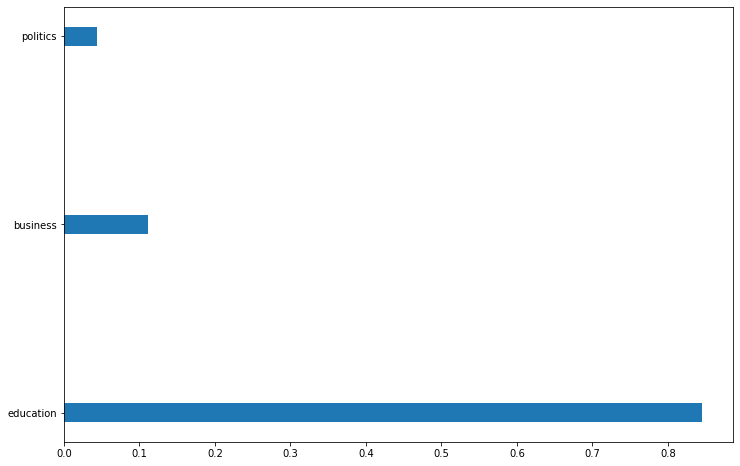

In [ ]:
result = classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

labels = result['labels']
probabilities = result['scores']

plt.figure(figsize=(12, 8))
plt.barh(labels, probabilities, height=0.1)
plt.show()

## Getting Started

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
model_name = "bert-base-uncased" #@param {type:"string"}
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

clear_output()

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]

In [ ]:
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

print("dict keys: ", inputs.keys())
print("input_ids[1]: ", inputs.input_ids[1])
print("attention_mask[1]: ", inputs.attention_mask[1])
print("input_ids.shape: ", inputs.input_ids.shape)

dict keys:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input_ids[1]:  tensor([ 101, 1045, 5223, 2023, 2061, 2172,  999,  102,    0,    0,    0,    0,
           0,    0,    0,    0])
attention_mask[1]:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
input_ids.shape:  torch.Size([2, 16])


In [ ]:
for token in inputs['input_ids'][0]:
  print(tokenizer.decode(token))

[CLS]
i
'
ve
been
waiting
for
a
hugging
##face
course
my
whole
life
.
[SEP]


In [ ]:
output = model(**inputs)

print("dict keys: ", output.keys())
print("last_hidden_state.shape: ", output['last_hidden_state'].shape)
print("pooler_output.shape: ", output['pooler_output'].shape)

dict keys:  odict_keys(['last_hidden_state', 'pooler_output'])
last_hidden_state.shape:  torch.Size([2, 16, 768])
pooler_output.shape:  torch.Size([2, 768])


### Using Transformers in PyTorch Model (Using Example From Previous Session)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
#@title Download and unzip the dataset
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
!unzip twitter-entity-sentiment-analysis
clear_output()
print('done')

done


In [ ]:
data = pd.read_csv('twitter_training.csv', header=None, names=['tweet_id', 'entity', 'label', 'content'])
data

,tweet_id,entity,label,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
data.label.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [ ]:
model_name = "roberta-base" #@param {type:"string"}
bert = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

clear_output()

In [ ]:
from sklearn import preprocessing
import numpy as np

class TwitterSentimentAnalysisDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file):
    super(TwitterSentimentAnalysisDataset, self).__init__()
    self.df = pd.read_csv('twitter_training.csv', header=None, names=['tweet_id', 'entity', 'label', 'content'])
    self.df = self.df.dropna(axis=0, subset=['content', 'label'])
    self.df.content = self.df.content.astype('string')
    self.label_encoder = preprocessing.LabelEncoder().fit(self.df['label'])
  
  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    input = self.df.iloc[index, 3]
    output = self.df.iloc[index, 2]
    output = self.label_encoder.transform([output])[0]
    return input, output
    # input = self.df.iloc[index, 3].split()
    # input = [word2ix[token] for token in input if token in word2ix]
    # input = [input[i] if i < len(input) else word2ix['<PAD>'] for i in range(32)]

    # output = self.df.iloc[index, 2]
    # output = self.label_encoder.transform([output])[0]
    
    # return torch.tensor(input), torch.tensor(output)

train_dataset = TwitterSentimentAnalysisDataset('twitter_training.csv')
validation_dataset = TwitterSentimentAnalysisDataset('twitter_validation.csv')

In [ ]:
MAX_LENGTH = 128 #@param {type:"integer"}
EMBEDDING_SIZE = bert.config.hidden_size

from torch.utils.data import DataLoader
from transformers import default_data_collator

def custom_collator(batch_input):
  input_texts = list(map(lambda x: x[0], batch_input))
  input_texts = tokenizer(input_texts, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
  labels = list(map(lambda x: x[1], batch_input))
  labels = torch.tensor(labels)
  # labels = labels.unsqueeze(1)
  return input_texts, labels

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collator)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True, collate_fn=custom_collator)


In [ ]:
class TwitterSentimentAnalysisModel(nn.Module):
  def __init__(self, bert):
    super(TwitterSentimentAnalysisModel, self).__init__()
    self.bert = bert
    self.linear1 = nn.Linear(32, 1)
    self.linear2 = nn.Linear(300, 100)
    self.linear3 = nn.Linear(100, 4)
  
  def forward(self, input_ids, attention_masks):
    x = self.bert(input_ids, attention_masks)['pooler_output']
    x = x.transpose(1, -1)
    x = self.linear1(x)
    x = F.relu(x)
    x = torch.squeeze(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    return F.softmax(x, dim=1)


In [ ]:
#@title Answer
class TwitterSentimentAnalysisModel(nn.Module):
  def __init__(self, bert):
    super(TwitterSentimentAnalysisModel, self).__init__()
    self.bert = bert
    self.linear1 = nn.Linear(MAX_LENGTH, 1)
    self.linear2 = nn.Linear(EMBEDDING_SIZE, 100)
    self.linear3 = nn.Linear(100, 4)
  
  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids, attention_mask)['last_hidden_state']
    x = x.transpose(1, -1)
    x = self.linear1(x)
    x = F.relu(x)
    x = torch.squeeze(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    return F.softmax(x, dim=1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = []
loss_function = nn.CrossEntropyLoss()
# model = TwitterSentimentAnalysisModel(weights).to(device)
# model.embedding.weight.required_grad = False
model = TwitterSentimentAnalysisModel(bert).to(device)
for param in model.bert.parameters():
    param.requires_grad = False
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
from sklearn import metrics

epoch_pbar = tqdm(range(1))
for epoch in epoch_pbar:
    total_loss = 0
    total_count = 0
    
    model.train()
    step_pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for content, label in step_pbar:
        input_ids = content['input_ids'].to(device)
        attention_mask = content['attention_mask'].to(device)

        model.zero_grad()
        log_probs = model(input_ids, attention_mask)
        loss = loss_function(log_probs, label.to(device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_count += 1
        step_pbar.set_postfix(loss=loss.item(), average_loss=total_loss/total_count)
        
        
    with torch.no_grad():
      validation_loss = 0
      validation_count = 0
      
      y_pred = np.array([])
      y_true = np.array([])
          
      model.eval()
      step_pbar = tqdm(validation_dataloader, total=len(validation_dataloader))
      step_pbar.set_description("Evaluation")

      for content, label in step_pbar:
          input_ids = content['input_ids'].to(device)
          attention_mask = content['attention_mask'].to(device)

          log_probs = model(input_ids, attention_mask)
          
          y_pred = np.append(y_pred, torch.argmax(log_probs, dim=-1).cpu().numpy())
          y_true = np.append(y_true, label.numpy())
          loss = loss_function(log_probs, label.to(device))
          
          validation_loss += loss.item()
          validation_count += 1
          step_pbar.set_postfix(loss=loss.item())
          
      
      step_pbar.set_postfix(average_loss=validation_loss/validation_count, 
                            accuracy=metrics.accuracy_score(y_true, y_pred))
      step_pbar.update()
      step_pbar.close()
      
      epoch_pbar.set_postfix(total_loss=total_loss, average_loss=total_loss/total_count)
      losses.append(total_loss)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Trainer API

In this step, we'll use the hugging face trainer API to train a classifier for our previous section's twitter sentiment analysis challenge.

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer

In [ ]:
#@title Download and unzip the dataset
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
!unzip twitter-entity-sentiment-analysis
clear_output()
print('done')

done


In [ ]:
def append_header(filename, header):
  header = ','.join(header)
  with open(filename, 'r') as original: data = original.read()
  with open(filename, 'w') as modified: modified.write(f'{header}\n' + data)

append_header('twitter_training.csv', ['id', 'entity', 'label', 'text'])
append_header('twitter_validation.csv', ['id', 'entity', 'label', 'text'])

In [ ]:
dataset = load_dataset('csv', data_files={'train': 'twitter_training.csv', 'val': 'twitter_validation.csv'})
dataset = dataset.filter(lambda x: x['text'] != None)

clear_output()
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'entity', 'label', 'text'],
        num_rows: 73996
    })
    val: Dataset({
        features: ['id', 'entity', 'label', 'text'],
        num_rows: 1000
    })
})

In [ ]:
model_name = "roberta-base" #@param {type:"string"}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
tokenizer = AutoTokenizer.from_pretrained(model_name)

clear_output()

In [ ]:
MAX_LENGTH = 128 #@param {type:"integer"}
LABEL_MAPPING = {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}

def tokenize_and_encode(example):
  example['label'] = list(map(lambda x: LABEL_MAPPING[x], example['label']))
  return tokenizer(example["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

tokenized_dataset = dataset.map(tokenize_and_encode, batched=True, load_from_cache_file=False, batch_size=64)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  0%|          | 0/1157 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

In [ ]:
training_args = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
columns_to_return = ['input_ids', 'label', 'attention_mask']
tokenized_dataset.set_format(type='torch', columns=columns_to_return)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, id, entity. If text, id, entity are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 73996
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27750


Step,Training Loss


KeyboardInterrupt: ignored